# Combining Tangelo, QEMIST Cloud and IBM Quantum for quantum experiments

This notebook demonstrates how problem decomposition from QEMIST Cloud can be combined with Tangelo and IBM's technology, in order to apply quantum computing to the study of chemical systems. It supported a brief presentation made at IBM Quantum Summit 2022, available on [Youtube](https://youtu.be/hPYFDGLmKZg?t=183). We meant to showcase how these different software can be combined, and how experiment on IBM Quantum are streamlined with Tangelo. We do not comment on the numerical results, as they are not the focus.

The use case for this study is a single Berylium atom in the cc-PVDZ basis. Tackled head-on with an algorithm such as VQE, this problem would require more than 25 qubits, and deep quantum circuits (thousands of gates for UCCSD). By approaching this problem with a more elaborate approach, it is possible to make this system more tractable for current devices and reduce resource requirements to about 6 qubits and much shallower circuits.

Here, we implement a workflow combining problem decomposition (MI-FNO), a quantum algorithm (custom QCC ADAPT approach), the IBM Kolkata device, and several post-processing techniques offered by IBM including Zero-Noise Extrapolation (ZNE). We share the experimental results obtained when attempting to compute the energy of a fragment of the system, using different noise-mitigation techniques available on the IBM devices.

We refer the reader to various dedicated notebook tutorials about the different techniques mentioned above, and detail some of them in the following sections.



## Setting up the environment

The installation of Tangelo, Qiskit and Qiskit-runtime is required for this notebook. 

In order to perform problem decomposition in QEMIST Cloud, users need to [sign up](https://goodchemistry.com/contact/) and install the client library in their environment. For simplicity, this notebook simply loads pre-computed MI-FNO results obtained from a previous run on QEMIST Cloud, and focuses on the quantum side of things.

In [ ]:
# Install: Tangelo, here directly from the develop branch on Github
!pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

# Install: qiskit, qiskit-runtime
!pip install qiskit --quiet
!pip install qiskit-ibm-runtime --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 KB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 KB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 6.5 MB/s eta 0:0

## Define use case

Briefly redefining our molecular system locally: a single berylium atom in the ccPVDZ basis.

In [ ]:
# Our molecular system
Be_coordinates = """
    Be    0.0000   0.0000   0.0000
"""
basis = "cc-pVDZ"
charge = 0 
spin = 0

#1. Importing QEMIST Cloud fragments into Tangelo

The [Method of Increment with Frozen Natural Orbital](https://aip.scitation.org/doi/abs/10.1063/5.0054647) (MI-FNO) was previously run with QEMIST Cloud, for our system of interest: a single atom of berylium in the ccPVDZ basis. The Heat-Bath CI (HBCI) classisal solver was used to solve individual fragments resulting from the MI-FNO decomposition.

Dedicated notebooks cover these steps. We load the pre-computed fragment information and references values. This system is small, and yields two one-body fragments and a single two-body fragment. The `MIFNOHelper` class enables us to load fragment data, and see how each of them contributes to the total energy of the system.

In [1]:
# Load pre-computed MI-FNO data, obtained with QEMIST Cloud
!unzip -qq ./data/Be_iso_VS1.zip

In [ ]:
from tangelo.problem_decomposition import MIFNOHelper

fno_fragments = MIFNOHelper(mi_json_file="./Be_iso_VS1/16435123521074770.json", fno_json_folder="./Be_iso_VS1/frags")
print(fno_fragments)

fno_fragments.retrieve_mo_coeff("./Be_iso_VS1/frags")

(All the energy values are in hartree)
Total MI-FNO energy = -14.60874953362714
Correlation energy = -0.03641190267375371
Mean-field energy = -14.572337630953388
         epsilon     problem_handle  energy_correlation  correction  \
(0,)   -0.000226  67697585423398483           -0.000226   -0.000161   
(1,)   -0.031890  24334728019588691           -0.031890   -0.017285   
(0, 1) -0.004297   2147133126882914           -0.036412   -0.019480   

        energy_total  
(0,)      -14.572563  
(1,)      -14.604227  
(0, 1)    -14.608750  


# 2. Reconstructing a fragment Hamiltonian

For this demonstration, we focus on fragment `(1,)`, which consists in a one-body problem that contributes quite a bit to the total energy of the system. Similarly, fragment `(0, 1)`, associated with a two-body problem, is also relevant and is however more computationally challenging (you can change the value of `frag` below to get a sense of that, and see what qubit operator comes out).

In [ ]:
from tangelo import SecondQuantizedMolecule

# Build Tangelo molecule object (includes HF calculation)
mol = SecondQuantizedMolecule(Be_coordinates, q=charge, spin=spin, basis=basis)

# Select a fragment,retrieve the number of electrons and spinorbitals
frag = "(1,)"
n_electrons, n_spinorbitals = fno_fragments.n_electrons_spinorbs(frag)
mol.freeze_mos(fno_fragments[frag]["frozen_orbitals_truncated"], inplace=True)

# Compute the Fermionic operator
ferm_op = fno_fragments.compute_fermionoperator(mol, frag)

#3. Designing our quantum experiment

At this point, we can make our own adventure in Tangelo. The experiment below uses:

- scBK qubit mapping
- ADAPT-VQE algorithm, using a custom pool of Qubit Coupled Cluster (QCC) operators
- a few post-processing techniques, including Zero-Noise Extrapolation.

In [ ]:
from tangelo.toolboxes.operators import count_qubits
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

# Apply qubit mapping
qu_op = fermion_to_qubit_mapping(ferm_op, "scBK", n_spinorbitals, n_electrons, up_then_down=True)
print(qu_op)

-14.402485811590493 [] +
0.07351153728840519 [X0 X1] +
0.08885408506584569 [Z0] +
0.007856350768804587 [Z0 Z1] +
0.0888540850658457 [Z1]


We define a custom pool of QCC operators, and use it with ADAPT-VQE, with the aim of producing a shallow quantum circuit for our fragment. The variational algorithm runs on a simulator, the user is free to specify a backend (cirq, qiskit, qulacs...) and behaviour, including a noise model. They can also define their own backend (see tutorials about our `linq` module).

In [ ]:
from tangelo.toolboxes.ansatz_generator._qubit_mf import init_qmf_from_hf
from tangelo.toolboxes.ansatz_generator._qubit_cc import construct_dis

# Custom function: define a pool of QCC operators
def qcc_pool(mol, mapping, up_then_down, qubit_hamiltonian):
    qmf_var_params = init_qmf_from_hf(mol.n_active_sos, mol.n_active_electrons, 
                                      mapping, up_then_down, mol.spin)
    dis = construct_dis(qubit_hamiltonian, qmf_var_params, 0.)
    return [item for sublist in dis for item in sublist]

In [ ]:
from tangelo.algorithms.variational import ADAPTSolver

pool_args = {"mol": mol, "mapping": "scBK", "up_then_down": True, "qubit_hamiltonian": qu_op}

opt_dict = {"molecule": mol, "tol": 0.01, "max_cycles": 5, 
            "qubit_mapping": "scbk", "up_then_down": True, 
            "n_spinorbitals": n_spinorbitals, "n_electrons": n_electrons,
            "pool": qcc_pool, "pool_args": pool_args}

solver = ADAPTSolver(opt_dict)
solver.build()
e = solver.simulate()

opt_circ = solver.vqe_solver.optimal_circuit

Let's take a look at this circuit. Tangelo provides a built-in `draw` method to visualize it, but since we support bidirectional conversion functions between multiple formats, it would be very easy for users to generate a qiskit equivalent and use the beautiful drawing features of that package as well !

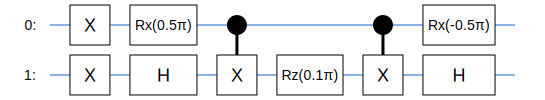

In [ ]:
opt_circ.draw()

Before running a quantum experiment, we always try to understand:
- the accuracy of the quantum approach itself (e.g compared to classical reference value)
- whether it is feasible and likely to be accurate enough on a target device (resource requirements mostly, sometimes running with a noise model)
- the anticipated cost ($)

We take a look at the resource requirements associated with our quantum circuit. The number of qubits and gates seems tractable for the IBM devices available to us. We find the number of 2-qubit gates relevant, as the these can significantly impact the accuracy of numerical results coming from superconducting devices at the time of writing. Finally, we get a sense of how accurate is our quantum alfgorithm in estimating the energy of that fragment. This gives us an idea of what we could hope from a device, in the ideal scenario that enough shots are drawn and that noise has been mitigated enough.

In [ ]:
# Count gates appearing in the circuit
print(opt_circ._gate_counts, "\n")

# Computation requirements associated with the algorithm
print(solver.get_resources())

# Error induced by using our quantum variational approach compared to classical reference value
print(f"\nFragment energy difference between reference value and noiseless quantum approach: "
      + f"{abs(e - (fno_fragments[frag]['energy_total'] - fno_fragments[frag]['correction'])):.5E} Ha")

{'X': 2, 'RX': 2, 'H': 2, 'CNOT': 2, 'RZ': 1} 

{'qubit_hamiltonian_terms': 5, 'circuit_width': 2, 'circuit_depth': 6, 'circuit_2qubit_gates': 2, 'circuit_var_gates': 1, 'vqe_variational_parameters': 1}

Fragment energy difference between reference value and noiseless quantum approach: 6.05324E-03 Ha


# 4. Running the experiment on IBM Quantum

For this experiment, we aim to compute the target fragment energy compare energies obtained with 3 different error-mitigation strategies:
- raw results (no error-mitigation)
- read-out error mitigation (ROEM), here implementing the T-REx method
- zero-noise extrapolation (ZNE) + ROEM


We first select our target device. For the purpose of cleaning up this notebook, the numerical results of some of the cells below were recomputed with a different backend or a simulator, but this does not alter the workflow or type of objects encountered. We share and plug the values obtained through running the same code on the Kolkata device from our experiments back then just before the final visualization.

In [ ]:
backend_name = 'ibm_qasm_simulator' # 'ibm_kolkata'

The `IBMConnection` class enables us to easily submit jobs to the IBM Quantum platform. As qiskit-runtime primitives are used under the hood, the installation of both `qiskit` and `qiskit-runtime` is necessary (see install section).

To instantiate the connection, the environment variable `IBM_TOKEN` need to be set with an acceptable value tied to an IBM Quantum account, or be passed as an argument (see documentation and install section).

In [ ]:
# Your IBM Quantum token should be found in your environment, to create the connection object.
import os
os.environ['IBM_TOKEN'] = 'your_ibm_quantum_token'

In [ ]:
from tangelo.linq.qpu_connection import IBMConnection

conn = IBMConnection()

### RAW results

#### Job submission

Using the connection object, we easily submit the job with `job_submit`. Here, we call the Estimator primitive of Qiskit-runtime to compute the expectation of our quantum circuit with regards to the qubit Hamiltonian of the fragment, using 1 million shots. The output is a job id.

The `runtime_options` variable is used to indicate we do not want any noise-mitigation to be applied by IBM Quantum. Variable names and values streamlined in Tangelo are mostly identical to the ones documented in qiskit-runtime, for transparency and simplicity.

In [ ]:
# RAW results
job_id_raw = conn.job_submit("estimator", backend_name, 10**6, opt_circ, qu_op, runtime_options={'resilience_level':0})
print(job_id_raw)

cfc6jonp2bp10gchkpi0


#### Job results

The `job_results` method retrieves the result of the job, saves them in the `IBMConnection` object, and returns here a list of 1 expectation values (as 1 circuit was submitted), without all the metadata attached. Note that it is a blocking call, and the cell would hang until the job is complete.

In [ ]:
expval_raw = conn.job_results(job_id_raw)

The `IBMConnection` class remembers previous jobs and their results and stores them in the format used by qiskit-runtime, providing access to all the metadata available on IBM Quantum. We store this in a dictionary attribute called `job_results`, indexed by job ids.

By using this metadata, we can access the variance and number of shots of the calculations, and compute the standard deviation of the expectation value. Error bars are important to keep track of in experiments, due to the statistical nature of quantum computing: this is valuable information. Here's what the computation may look like on a device (`values` contains the expectation values):

In [ ]:
# Access full data of complete jobs
raw_results = conn.jobs_results[job_id_raw]
print(raw_results)

EstimatorResult(values=array([-14.56441683]), metadata=[{'variance': 0.010114398620993439, 'shots': 100000}])


It may take a long time for your job to run and complete, and your python script or notebook may terminate or disconnect before that. Through a `QiskitRuntimeService` object, qiskit-runtime users can retrieve data for a past job. Our `IBMConnection` object exposes such an object through its `service` attribute as well, and we can use that to bring back results obtained from previous runs if needed.

``` python
job = conn.service.job(job_id)
my_results = job.result()
```

Regardless of how the metadata was retrieved, we can now compute the standard deviation of our expectation value using it.

In [ ]:
import numpy as np

data_raw = (raw_results.values[0], np.sqrt(raw_results.metadata[0]['variance'] / raw_results.metadata[0]['shots']))
print(data_raw)

(-14.564416825107253, 0.0003180314233058337)


### ROEM and ZNE results

If you'd like to know more about readout error-mitigation (here abbreviated as ROEM)and ZNE, here's [some documentation from IBM](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/Error-Suppression-and-Error-Mitigation.html). The technique used for error mitigation is called T-REx. Here we just show how these features are streamlined through Tangelo and our `IBMConnection` object: it's as simple as changing the value of the `resilience_level` in the `runtime_option` dictionary.

Although IBM Quantum provides a streamlined way to perform ZNE (see link above), there is no streamlined way to both apply ZNE and ROEM at the time of writing. We thus manually perform a linear ZNE using two datapoints corresponding to noise levels 1 and 3. The latter is obtained by running our quantum circuit and replicating CNOT gates to amplify noise (e.g inserting 3 consecutive CNOT gates instead of 1). We define a simple function to produce that circuit, using the original one as input (NB: since there are only two qubits in our example, barrier operations are not required).

In [ ]:
from tangelo.linq import Gate, Circuit

def repeat_CNOT(circ, n_repeat):

  gates = []
  for g in circ:
      n = n_repeat if g.name == 'CNOT' else 1
      gates += [g]*n
  return Circuit(gates)

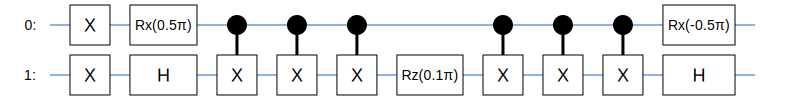

In [ ]:
opt_circ3 = repeat_CNOT(opt_circ, 3)
opt_circ3.draw()

Because the noise characterization of a device changes, batch submission of circuits is important to make sure all data is obtained in similar conditions and the jobs are not run several hours apart, for example. We thus submit both circuits simultaneously by providing circuits and operators as lists of 2 elements.

We here force `optimization_level` to be `0`, because it turns out the default value (`1`) means IBM Quantum currently optimizes the extra CNOTs away, although we do need the device to execute them and amplify the noise for ZNE.

In [ ]:
# ROEM results (T-REx)
job_id_roem = conn.job_submit("estimator", backend_name, 10**6, [opt_circ, opt_circ3], [qu_op]*2, 
                              runtime_options={'resilience_level':1, 'optimization_level':0})
print(job_id_roem) 

In [ ]:
# Retrieve results
conn.job_results(job_id_roem)
roem_results = conn.jobs_results[job_id_roem]

We derive the standard deviation of the resulting expectation values for each of our two data points, stored into tuples.

In [ ]:
data_roem   = (roem_results.values[0], np.sqrt(roem_results.metadata[0]['variance'] / roem_results.metadata[0]['shots']))
data_roem_3 = (roem_results.values[1], np.sqrt(roem_results.metadata[1]['variance'] / roem_results.metadata[1]['shots']))

print(data_roem)
print(data_roem_3)

(-14.582281356801207, 0.00010402729980565454)
(-14.550073443064663, 0.00012629566832783953)


Tangelo provides an implementation of Richardson's extrapolation, which helps us derive the ZNE datapoint. This function generalizes to an arbitrary number of input data points and take as input their noise levels, the corresponding expectation values and their standard deviations.

In [ ]:
from tangelo.toolboxes.post_processing.extrapolation import richardson_analytical

# Use data_roem and data_roem_3 to compute ZNE results
noise_levels = [1, 3]
energies = [data_roem[0], data_roem_3[0]]
stderr = [data_roem[1], data_roem_3[1]]

data_roem_zne = richardson_analytical(noise_levels, energies, stderr)
print(data_roem_zne)

(-14.58553651, 0.00015233875934902451)


## 5. Visualization of results

We cleaned up and tested this notebook several weeks after running our experiment on Kolkata (Oct 2022), and the values from the cells above were obtained on other backends, for convenience. When we ran those calculations on Kolkata, we obtained the numerical results below. We plug them into the final cell, which illustrates how we built the final visualization of the results with matplotlib.

As you can see, the `roem3` datapoint shows that in our experiment the additional CNOTs definitely amplified the noise and degraded the results of the calculation: the outcome was even worse than raw results.

In [ ]:
# Data obtained with Kolkata in October 2022, for the final plot
data_raw      = (-14.57206231, 0.00009134)
data_roem     = (-14.58389566, 0.00009584)
data_roem3    = (-14.58061396, 0.00010080)
data_roem_zne = (-14.58553651, 0.00015234)

Let's plot these results. The dashed line shows the mean-field energy, the continuous line the exact MI-FNO energy, and the gray band what is within chemical accuracy.

Energy difference between exact value and ZNE results: 1.406e-03



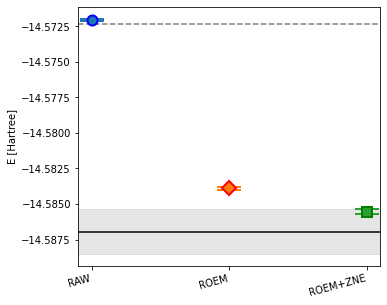

In [ ]:
import matplotlib.pyplot as plt

e_ref_frag = fno_fragments[frag]["energy_total"] - fno_fragments[frag]["correction"]
e_hf_frag = mol.mf_energy
chem_acc_error = 1.59e-3

fig,ax   = plt.subplots(1,1,figsize=(6,8))
fig.subplots_adjust(hspace=0.0,wspace=0.0,bottom=0.25,left=0.2,top=0.7)

ax.axhline(e_hf_frag,ls='--',color='gray')
ax.axhline(e_ref_frag,ls='-',color='black')
ax.axhspan(e_ref_frag - chem_acc_error, e_ref_frag + chem_acc_error, color='gray',alpha=0.2)

ax.errorbar([0],data_raw[0],yerr=data_raw[1], marker='o', capsize=12,ms=10,mew=2,mec='b')
ax.errorbar([1],data_roem[0],yerr=data_roem[1],marker='D',capsize=12,ms=10,mew=2,mec='r')
ax.errorbar([2],data_roem_zne[0],yerr=data_roem_zne[1],marker='s',capsize=12,ms=10,mew=2,mec='g')

ax.set_ylabel('E [Hartree]');
ax.set_xticks([0,1,2]); ax.set_xticklabels(['RAW','ROEM','ROEM+ZNE'],rotation=15,ha='right',fontsize=10);

print(f"Energy difference between exact value and ZNE results: {abs(e_ref_frag - data_roem_zne[0]):.3e}\n")

# Closing words

Tangelo is a powerful and flexible tool enabling users to study quantum systems, with streamlined integration to qiskit and qiskit-runtime. Tangelo users can easily submit experiments to backends available on IBM Quantum and leverage the features of the service.

The combination of QEMIST Cloud and Tangelo allows users to explore the potential of quantum computing on systems that may otherwise be out of reach for current devices, by decomposing a problem into smaller subproblems requiring less resources and implementing workflow combining shallow circuits and noise-mitigation techniques. In this example, a system that would require 25+ qubits and circuits too deep for current devices was reduced to a few smaller problems requiring up to 6 qubits and much shallower circuits, making it more tractable for NISQ hardware.

What will you do with Tangelo, QEMIST Cloud, and IBM Quantum ?